### Sharpe Strategy Worker Workflow

This notebook executes a single backtest iteration for a given train/test data split. It is designed to be called by an orchestrator notebook (`py11_backtest_orchestrator.ipynb`) via `papermill`.

**Workflow:**

1.  **Receive Parameters:** Papermill injects paths for train/test data, Finviz data, the output location, and the benchmark ticker.
2.  **Load Data:** Reads the data from the specified paths.
3.  **Calculate Sharpe & Filter:** Calculates Sharpe ratios over multiple lookback periods within the training data and filters for tickers that consistently underperform the benchmark.
4.  **Determine Weights:** Assigns equal weights to the selected underperforming tickers.
5.  **Simulate & Compare:** Runs a simulation on the test data, comparing the portfolio's performance against the benchmark.
6.  **Save Results:** Saves the daily portfolio and benchmark returns for the test period to the specified output path.

### Step 1: Setup and Parameters

This cell imports necessary libraries and defines the parameters that will be injected by `papermill`. **Do not modify the `Parameters` section manually when running via the orchestrator.**

In [9]:
# Papermill injects parameters here
# Add parameter tag -> Open Command Palette (ctrl+ shift+ p) -> Add Cell Tag -> parameters 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Parameters ---
# [REFACTOR] This cell is now tagged as the 'parameters' cell for papermill.
# Default values are provided for interactive testing, but will be overwritten.
returns_train_path = "path/to/train_data.parquet"
returns_test_path = "path/to/test_data.parquet"
finviz_data_path = "path/to/finviz_data.parquet"
output_path = "path/to/output.parquet"
benchmark_ticker = "VGT"

# --- Verification (runs inside the notebook) ---
print("--- Worker Notebook Execution Started ---")
print(f"Train data path: {returns_train_path}")
print(f"Test data path:  {returns_test_path}")
print(f"Output path:     {output_path}")
print(f"Benchmark:       {benchmark_ticker}")

--- Worker Notebook Execution Started ---
Train data path: path/to/train_data.parquet
Test data path:  path/to/test_data.parquet
Output path:     path/to/output.parquet
Benchmark:       VGT


In [10]:
# Parameters
returns_train_path = "c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\colab\\temp_backtest_data\\returns_train_chunk_0.parquet"
returns_test_path = "c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\colab\\temp_backtest_data\\returns_test_chunk_0.parquet"
finviz_data_path = "c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\colab\\2025-08-01_df_finviz_merged_stocks_etfs.parquet"
output_path = "c:\\Users\\ping\\Files_win10\\python\\py311\\stocks\\colab\\backtest_results\\result_chunk_0.parquet"
benchmark_ticker = "VGT"


### Step 2: Load Data

Load the training and testing datasets using the paths provided by the orchestrator.

In [11]:
# Convert string paths from papermill to Path objects
returns_train_path = Path(returns_train_path)
returns_test_path = Path(returns_test_path)
finviz_data_path = Path(finviz_data_path)

# Load data
returns_train = pd.read_parquet(returns_train_path)
returns_test = pd.read_parquet(returns_test_path)
df_finviz = pd.read_parquet(finviz_data_path)

print(f"Loaded training data with shape: {returns_train.shape}")
print(f"Loaded testing data with shape: {returns_test.shape}")

Loaded training data with shape: (270, 1151)
Loaded testing data with shape: (30, 1151)


### Step 3: Calculate Sharpe Ratios and Filter Tickers

Analyze the training data to select tickers for our portfolio. The strategy is to select assets that have consistently lower Sharpe ratios than the benchmark over multiple time horizons.

In [12]:
def calculate_sharpe(returns: pd.Series) -> float:
    """Calculates the Sharpe ratio for a returns series."""
    # Note: This is a simplified Sharpe ratio (risk-free rate = 0).
    # For annualized Sharpe, adjustments would be needed.
    if returns.std() == 0:
        return 0.0
    return returns.mean() / returns.std()

In [15]:
days = 30
sharpe_ratios = {}
sharpe_ratios[days] = returns_train.iloc[-days:].apply(calculate_sharpe)

In [18]:
returns_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 270 entries, 2015-01-05 to 2016-01-29
Columns: 1151 entries, A to CASH
dtypes: float64(1151)
memory usage: 2.4 MB


In [ ]:
returns_train.iloc[-days:]

In [22]:
sharpe_ratios[30]["A"]

-0.13444110002747853

In [23]:
def calculate_sharpe(returns: pd.Series) -> float:
    """Calculates the Sharpe ratio for a returns series."""
    # Note: This is a simplified Sharpe ratio (risk-free rate = 0).
    # For annualized Sharpe, adjustments would be needed.
    if returns.std() == 0:
        return 0.0
    return returns.mean() / returns.std()

# Define lookback periods
lookbacks = [30, 60, 120, 240]
sharpe_ratios = {}

# Calculate Sharpe for each lookback period
for days in lookbacks:
    if len(returns_train) >= days:
        sharpe_ratios[days] = returns_train.iloc[-days:].apply(calculate_sharpe)

# Find tickers that consistently underperform the benchmark
if sharpe_ratios:
    # Start with all tickers
    candidate_tickers = returns_train.columns.drop('CASH')
    
    # Iteratively filter the list
    for days, sr_series in sharpe_ratios.items():
        benchmark_sharpe = sr_series.get(benchmark_ticker, -np.inf)

        # underperformers = sr_series[sr_series < benchmark_sharpe].index
        #candidate_tickers = candidate_tickers.intersection(underperformers)        
        
        overperformers = sr_series[sr_series > benchmark_sharpe].index        
        candidate_tickers = candidate_tickers.intersection(overperformers)
        print(f'days: {days}, len(candidate_tickers): {len(candidate_tickers)}')

    selected_tickers = candidate_tickers.tolist()
else:
    selected_tickers = []

print(f"Found {len(selected_tickers)} tickers that consistently underperformed '{benchmark_ticker}'.")
print(f"Selected tickers: {selected_tickers}")

days: 30, len(candidate_tickers): 784
days: 60, len(candidate_tickers): 590
days: 120, len(candidate_tickers): 412
days: 240, len(candidate_tickers): 326
Found 326 tickers that consistently underperformed 'VGT'.
Selected tickers: ['AAON', 'ACN', 'ADBE', 'ADC', 'ADP', 'AEE', 'AEM', 'AEP', 'AFG', 'AGG', 'AIZ', 'ALB', 'AMZN', 'ARMK', 'ATO', 'ATR', 'AVB', 'AVGO', 'AVY', 'AWK', 'AZN', 'AZO', 'B', 'BAH', 'BBWI', 'BDX', 'BFAM', 'BIV', 'BLV', 'BND', 'BNDX', 'BOND', 'BRKR', 'BRX', 'BSV', 'BSX', 'BUD', 'BURL', 'BWXT', 'BYD', 'CAH', 'CASY', 'CB', 'CBOE', 'CCI', 'CHDN', 'CHT', 'CINF', 'CL', 'CLX', 'CME', 'CMF', 'CMS', 'COHR', 'COOP', 'CPB', 'CPT', 'CRL', 'CTAS', 'CUBE', 'CW', 'CWST', 'D', 'DEO', 'DG', 'DLR', 'DLTR', 'DPZ', 'DRI', 'DSGX', 'DTE', 'DUK', 'EBR', 'ED', 'EDV', 'EFX', 'EG', 'EIX', 'ELS', 'EMA', 'EMB', 'EME', 'ENSG', 'EQIX', 'EQR', 'ERIE', 'ES', 'ESLT', 'EVRG', 'EW', 'EXR', 'FAST', 'FCNCA', 'FDL', 'FI', 'FICO', 'FIVE', 'FIX', 'FLUT', 'FMS', 'FMX', 'FN', 'FNV', 'FPE', 'FR', 'FRT', 'FSLR', 

### Step 4: Determine Portfolio Weights

Allocate weights to the selected tickers. If no tickers are selected, the portfolio defaults to 100% cash.

In [5]:
if selected_tickers:
    num_tickers = len(selected_tickers)
    uniform_weight = 1.0 / num_tickers
    selected_weights = np.full(num_tickers, uniform_weight)
    print(f"Assigned uniform weight of {uniform_weight:.4f} to {num_tickers} tickers.")
else:
    # Default to a cash position if no tickers meet the criteria
    selected_tickers = ['CASH']
    selected_weights = np.array([1.0])
    print("No tickers selected. Defaulting to 100% CASH position.")

Assigned uniform weight of 0.0031 to 326 tickers.


### Step 5: Simulate Portfolio on Test Data

Apply the calculated weights to the test data returns to simulate the portfolio's performance.

In [6]:
# Filter test returns for selected tickers and calculate portfolio daily return
portfolio_returns_test = returns_test[selected_tickers].dot(selected_weights)

# Create a results DataFrame including the benchmark for comparison
results_df = pd.DataFrame({
    'Portfolio': portfolio_returns_test,
    'Benchmark': returns_test[benchmark_ticker]
})

print("Simulation on test data complete.")
display(results_df.head(3))

Simulation on test data complete.


,Portfolio,Benchmark
Date,,
2016-02-01,0.002070,0.002452
2016-02-02,-0.008647,-0.020258
2016-02-03,0.002134,-0.002297


### Step 6: Save Results

Save the resulting portfolio and benchmark daily returns to the specified output file. This file will be collected by the orchestrator.

In [7]:
# [REFACTOR] Saving to a unique parquet file. The orchestrator will handle aggregation.
output_path = Path(output_path)
output_path.parent.mkdir(parents=True, exist_ok=True) # Ensure directory exists

results_df.to_parquet(output_path)

print(f"Successfully saved test period results to: {output_path}")

Successfully saved test period results to: c:\Users\ping\Files_win10\python\py311\stocks\colab\backtest_results\result_chunk_0.parquet


### Step 7: Verification and Analysis (Optional)

This cell provides a quick visualization of the test period's performance. The final, aggregated analysis should be done in a separate notebook after the orchestrator finishes.

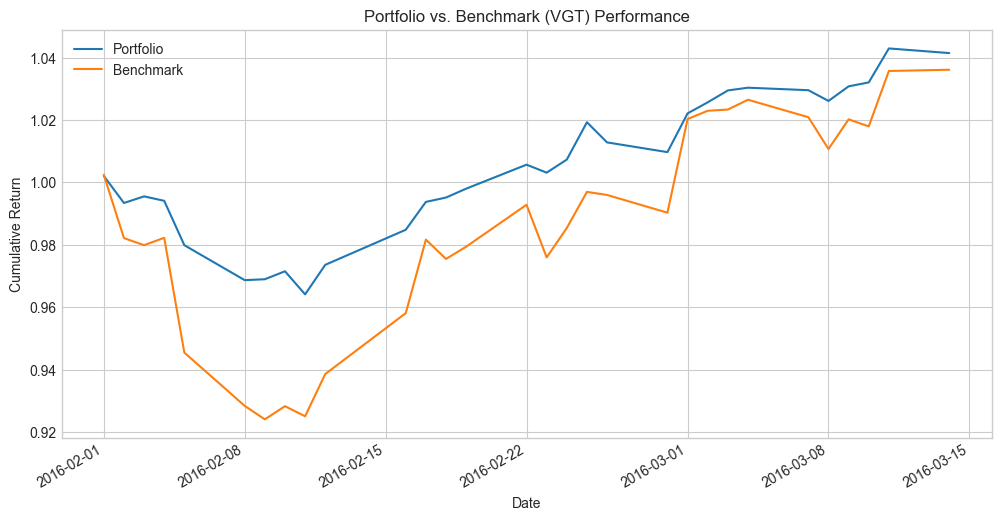

In [8]:
# Calculate cumulative returns for plotting
cumulative_results = (1 + results_df).cumprod()

# Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
cumulative_results.plot(ax=ax)

ax.set_title(f'Portfolio vs. Benchmark ({benchmark_ticker}) Performance')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
ax.legend(['Portfolio', 'Benchmark'])
plt.show()